In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [3]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [4]:
models = {
    "deepseek-ai/deepseek-chat": {
        "label": "DeepSeek-V3", 
        "color": "#FADFA1",
    },
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepSeek-R1", 
        "color": "#FFD166",
    },   
    "alibaba/qwen2.5-32b-instruct": {
        "label": "Qwen2.5-32B", 
        "color": "#687B85", # "#7EADC6",
    },
    "openrouter-qwen/qwq-32b": {
        "label": "QwQ-32B", 
        "color": "#073B4C", # "#118AB2",
    },
}


metrics = {
    "average_forgetting_rate": {
        "label": r'$r_{\mathrm{forget}}$',
    },
    "average_solution_count": {
        "label": r'$\mathrel{\#}_{\mathrm{solution}}$',
    },
    "overall_average_verification_rate": {
        "label": r"$r_{\mathrm{verify}}$",
    },
    "filtered_ajd": {
        "label": r'$d_{\mathrm{jump}}$',
    },
    "average_success_rate": {
        "label": r'$r_{\mathrm{success}}$',
    },
    "average_overthinking_rate": {
        "label": r'$r_{\mathrm{overthinking}}$',
    },
    "average_correlation": {
        "label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}

final_datasets = {
    'math500': "MATH-500", 
    'game24': "Game of 24",
}
final_metrics = [
    "average_correlation", 
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "average_overthinking_rate",
    "overall_average_verification_rate",
    "average_forgetting_rate",
]

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
reasoning_metrics = {}
for dataset in final_datasets:
    reasoning_metrics[dataset] = {}
    for model in models:
        
        row = get_row(
            task_vis_results, 
            model_name=model, 
            dataset_name=dataset, 
            temperature = 0,
        )
        for metric in final_metrics:
            if metric not in reasoning_metrics[dataset]:
                reasoning_metrics[dataset][metric] = {}

            reasoning_metrics[dataset][metric][model] = row.iloc[0][metric]


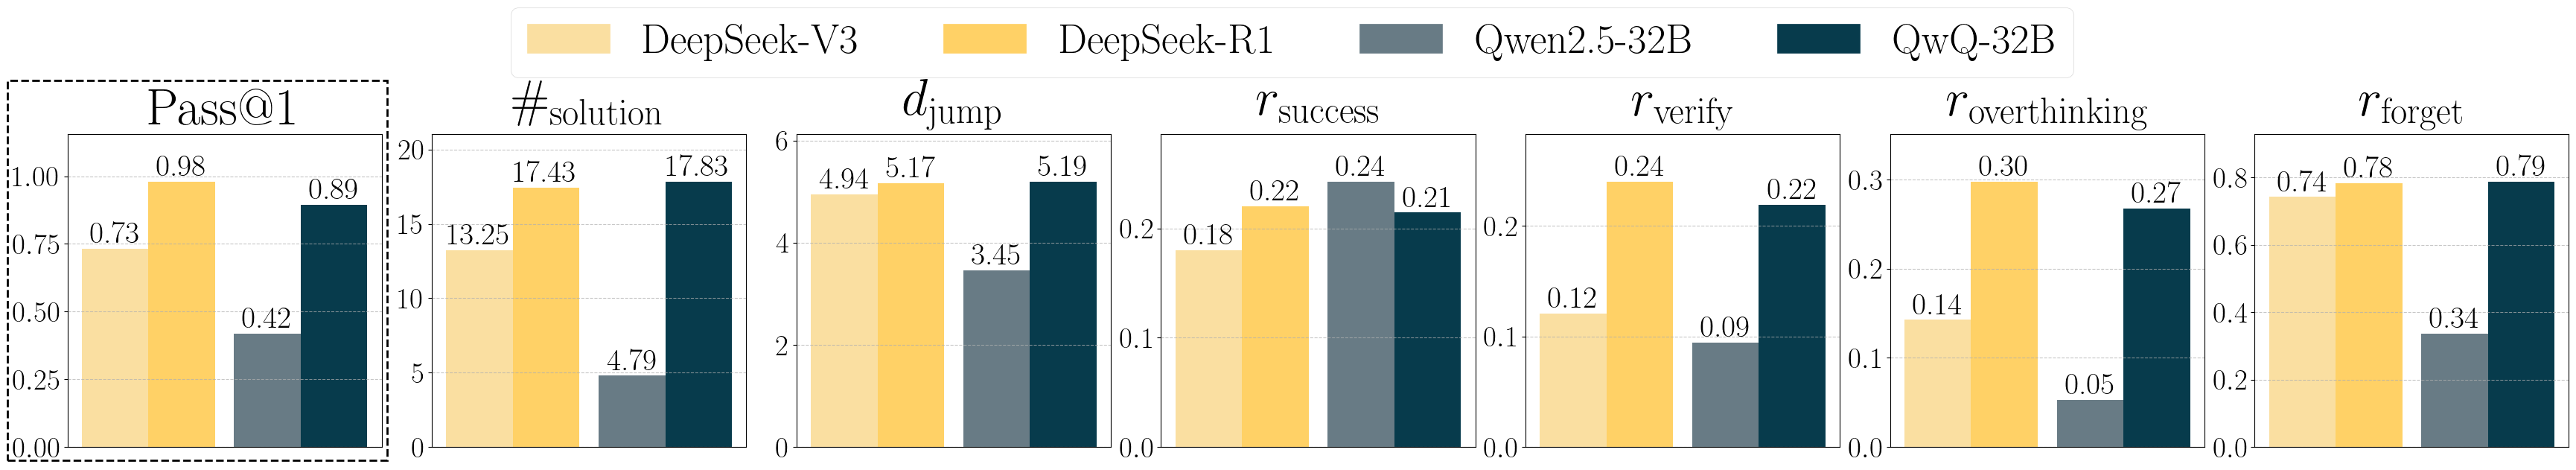

In [7]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a figure with 1 row and 7 columns
fig, axs = plt.subplots(1, 7, figsize=(35, 6)) # Adjusted figsize
# Adjusted top for legend, bottom for potential x-axis label space if needed later (though currently empty)
fig.subplots_adjust(left=0.03, bottom=0.15, right=0.99, top=0.85, wspace=0.16) 

# Set width of individual bars and gap between groups
individual_bar_width = 0.35  # Width of each bar
group_gap = 0.1             # Space between the two groups of bars

dataset_key_to_plot = 'game24'
dataset_display_name = final_datasets[dataset_key_to_plot]

model_keys = list(models.keys())
# Using display labels for the legend directly
model_display_labels_for_legend = [models[m]["label"] for m in model_keys]
model_colors = [models[m]["color"] for m in model_keys]

# Calculate bar positions for grouping
calculated_positions = []
calculated_positions.append(0) 
calculated_positions.append(individual_bar_width) 
calculated_positions.append(individual_bar_width * 2 + group_gap) 
calculated_positions.append(individual_bar_width * 3 + group_gap) 


# Plot each metric in its own subplot
for col_idx, metric_key in enumerate(this_metrics):
    ax = axs[col_idx]
    metric_display_name = metrics[metric_key]["label"]

    if col_idx == 0: 
        ax.set_title(f"{metric_display_name}", fontsize=50, y=1.01) 
    else:
        ax.set_title(metric_display_name, fontsize=50, y=1.04) 

    metric_values = [reasoning_metrics[dataset_key_to_plot][metric_key][m] for m in model_keys]

    ax.bar(calculated_positions, metric_values, width=individual_bar_width, color=model_colors)

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    min_y_val = 0
    if any(val < 0 for val in metric_values) and metric_key == "average_correlation":
        min_val_actual = min(metric_values)
        min_y_val = min_val_actual - abs(min_val_actual * 0.1) 
    
    current_max_y = max(metric_values) if metric_values else 0
    if all(val == 0 for val in metric_values): 
        if metric_key == "average_correlation" and any(val < 0 for val in metric_values):
             max_y_padding_base = max(0.1, abs(min_y_val * 0.2)) 
        elif current_max_y == 0 and min_y_val == 0 : 
            max_y_padding_base = 0.1 
        else: 
            max_y_padding_base = abs(min_y_val) * 0.2 if min_y_val < 0 else current_max_y + 0.1
        max_y_val_adjusted = current_max_y + max_y_padding_base * 1.18 
        if max_y_val_adjusted == 0: max_y_val_adjusted = 0.1 
    else: 
        max_y_val_adjusted = current_max_y + abs(current_max_y - min_y_val) * 0.18 if current_max_y != min_y_val else current_max_y + 0.18

    ax.set_ylim(min_y_val, max_y_val_adjusted)

    for i, value in enumerate(metric_values):
        ax.text(calculated_positions[i], value, f'{value:.2f}', ha='center', va='bottom', fontsize=30)

# Add a dashed box around the first subplot (axs[0])
pos_ax0 = axs[0].get_position()
rect = plt.Rectangle(
    (pos_ax0.x0 - 0.023, pos_ax0.y0 - 0.03),  
    pos_ax0.width + 0.025,  
    pos_ax0.height + 0.15,  
    linewidth=2,
    linestyle='dashed',
    edgecolor='black',
    facecolor='none',
    zorder=1000, 
    transform=fig.transFigure,
    clip_on=False 
)
fig.add_artist(rect)

# Create legend handles and labels manually
legend_handles = [plt.Rectangle((0,0),1,1, color=models[m_key]["color"]) for m_key in model_keys]
# Use model_display_labels_for_legend for the legend text
fig.legend(legend_handles, model_display_labels_for_legend, 
           loc='upper center', bbox_to_anchor=(0.5, 1.18), # Adjusted y for legend position
           ncol=len(models), frameon=True, fontsize=40) # Adjusted fontsize

# suptitle removed as per request

plt.savefig(f"{root_dir}/figures/lrmllm.pdf",bbox_inches='tight') 
plt.show()